# Single-cell RNA Sequencing of Fibrotic Skin Disease Dermis Tissue and Normal  Dermise Tissue

**Data Source Acknowledgment:**

The dataset is sourced from [GSE163973](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE163973). This dataset comprises single-cell RNA sequencing data from keloid (nsample=3) and normal scar(nsample=3).

Reference: Deng CC, Hu YF, Zhu DH, Cheng Q et al. Single-cell RNA-seq reveals fibroblast heterogeneity and increased mesenchymal fibroblasts in human fibrotic skin diseases. Nat Commun 2021 Jun 17;12(1):3709. PMID: 34140509


It's essential to emphasize that this dataset is exclusively utilized for Python practice purposes within this repository. This notebook will use this dataset to practice data cleaning techniques and clustering.

In [48]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data Loading

The raw data file (GSE163973_RAW.tar) is unzipped, revealing archives for 6 samples, each compressed in separate .tar.gz files named "sample_file.tar.gz." Unzipping each sample file  (.tar.gz) will get you three files: matrix.mtx.gz, barcodes.tsv.gz, and features.tsv.gz.

The ```scanpy.read_10x_mtx function``` is used to read data in the 10x Genomics matrix format, which requires these three files (matrix.mtx.gz, barcodes.tsv.gz, and features.tsv.gz) for each sample.

- matrix.mtx.gz :  a matrix of count values, where rows are associated with the gene IDs and columns correspond to the cellular barcodes. I will use the sparse matrix instead of the dense matrix which improves the amount of space, memory and CPU.
- barcodes.tsv.gz : cellular barcodes present in dataset
- features.tsv.gz : IDs of quantified genes

In [2]:
from unzip_raw_10x_mtx import prep_10xmtx_directory
file_path = '.'
prep_10xmtx_directory(file_path)

In [3]:
path = "./KF1_matrix/"
adata = sc.read_10x_mtx(path)

In [7]:
adata

AnnData object with n_obs × n_vars = 9663 × 33538
    var: 'gene_ids', 'feature_types'

In [6]:
#X is sparse matrix
adata

AnnData object with n_obs × n_vars = 9663 × 33538
    var: 'gene_ids', 'feature_types'

# 2. Droplet removal

In [8]:
sc.pp.filter_genes(adata, min_cells = 10)

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [10]:
adata

AnnData object with n_obs × n_vars = 9663 × 2000
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [11]:
import scvi
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/Applications/anaconda3/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Applications/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [26:01<00:00,  4.60s/it, v_num=1, train_loss_step=729, train_loss_epoch=666]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [26:01<00:00,  3.90s/it, v_num=1, train_loss_step=729, train_loss_epoch=666]


In [12]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Applications/anaconda3/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Applications/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Applications/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to

Epoch 340/400:  85%|██████████████████████████████████████████████████████████████████████████████▏             | 340/400 [04:10<00:44,  1.35it/s, v_num=1, train_loss_step=0.427, train_loss_epoch=0.283]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.262. Signaling Trainer to stop.


In [24]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df

,doublet,singlet,prediction
AAACCCAAGAACAGGA-1,-1.667292,1.404067,singlet
AAACCCAAGATCCTAC-1,-0.925931,0.690755,singlet
AAACCCAAGCCTGACC-1,-0.881469,0.679643,singlet
AAACCCAAGCGCAATG-1,-0.901936,0.856780,singlet
AAACCCACAAACTCGT-1,-1.880207,1.551739,singlet
...,...,...,...
TTTGTTGGTCGGTACC-1,-3.298267,3.038211,singlet
TTTGTTGGTCTAGGTT-1,-3.462393,3.302976,singlet
TTTGTTGGTGATGGCA-1,-2.184061,2.136050,singlet
TTTGTTGGTTCTATCT-1,-1.145114,1.045290,singlet


In [25]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1930,1930
singlet,7733,7733


In [26]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
AAACCCAAGAACAGGA-1,-1.667292,1.404067,singlet,-3.071360
AAACCCAAGATCCTAC-1,-0.925931,0.690755,singlet,-1.616686
AAACCCAAGCCTGACC-1,-0.881469,0.679643,singlet,-1.561112
AAACCCAAGCGCAATG-1,-0.901936,0.856780,singlet,-1.758716
AAACCCACAAACTCGT-1,-1.880207,1.551739,singlet,-3.431946
...,...,...,...,...
TTTGTTGGTCGGTACC-1,-3.298267,3.038211,singlet,-6.336478
TTTGTTGGTCTAGGTT-1,-3.462393,3.302976,singlet,-6.765369
TTTGTTGGTGATGGCA-1,-2.184061,2.136050,singlet,-4.320111
TTTGTTGGTTCTATCT-1,-1.145114,1.045290,singlet,-2.190404


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


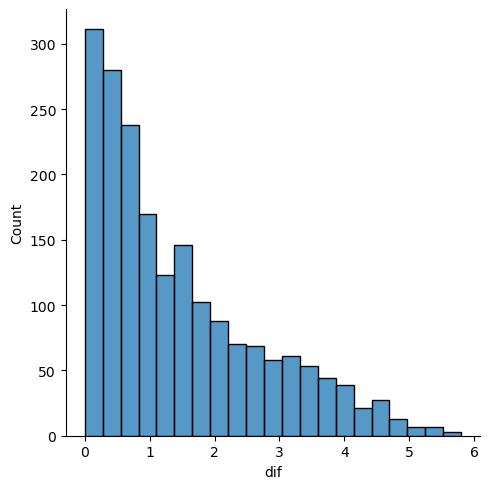

In [27]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [28]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
AAACGAAGTCCACGCA-1,0.814945,-0.505267,doublet,1.320211
AAACGCTAGTTTGAGA-1,1.494178,-1.734427,doublet,3.228605
AAACGCTGTCGTAATC-1,0.481942,-1.084689,doublet,1.566631
AAAGAACAGCTATCCA-1,0.297576,-1.435378,doublet,1.732954
AAAGAACGTGTCCATA-1,0.828097,-0.880979,doublet,1.709076
...,...,...,...,...
TTTGATCTCTTGATTC-1,2.406200,-2.049244,doublet,4.455444
TTTGGAGAGAAAGCGA-1,1.437973,-1.518289,doublet,2.956262
TTTGGAGCACTTCAAG-1,1.034311,-0.364286,doublet,1.398597
TTTGGAGCACTTGTGA-1,0.994256,-0.586882,doublet,1.581138


In [74]:
path = "./KF1_matrix/"
adata = sc.read_10x_mtx(path)

In [75]:
adata.obs

""
AAACCCAAGAACAGGA-1
AAACCCAAGATCCTAC-1
AAACCCAAGCCTGACC-1
AAACCCAAGCGCAATG-1
AAACCCACAAACTCGT-1
...
TTTGTTGGTCGGTACC-1
TTTGTTGGTCTAGGTT-1
TTTGTTGGTGATGGCA-1
TTTGTTGGTTCTATCT-1


In [76]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

,doublet
AAACCCAAGAACAGGA-1,False
AAACCCAAGATCCTAC-1,False
AAACCCAAGCCTGACC-1,False
AAACCCAAGCGCAATG-1,False
AAACCCACAAACTCGT-1,False
...,...
TTTGTTGGTCGGTACC-1,False
TTTGTTGGTCTAGGTT-1,False
TTTGTTGGTGATGGCA-1,False
TTTGTTGGTTCTATCT-1,False


In [77]:
adata = adata[~adata.obs.doublet]
adata

View of AnnData object with n_obs × n_vars = 8658 × 33538
    obs: 'doublet'
    var: 'gene_ids', 'feature_types'

# 3. Preprocessing

In [78]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

/var/folders/ly/mwzzbn7j7yd69hdl9hq_23540000gn/T/ipykernel_26516/310233584.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [79]:
adata.var

,gene_ids,feature_types,mt
MIR1302-2HG,ENSG00000243485,Gene Expression,False
FAM138A,ENSG00000237613,Gene Expression,False
OR4F5,ENSG00000186092,Gene Expression,False
AL627309.1,ENSG00000238009,Gene Expression,False
AL627309.3,ENSG00000239945,Gene Expression,False
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,False
AC233755.1,ENSG00000275063,Gene Expression,False
AC240274.1,ENSG00000271254,Gene Expression,False
AC213203.1,ENSG00000277475,Gene Expression,False


In [80]:
import pandas as pd
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [81]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [82]:
adata.var

,gene_ids,feature_types,mt,ribo
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False
FAM138A,ENSG00000237613,Gene Expression,False,False
OR4F5,ENSG00000186092,Gene Expression,False,False
AL627309.1,ENSG00000238009,Gene Expression,False,False
AL627309.3,ENSG00000239945,Gene Expression,False,False
...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,False,False
AC233755.1,ENSG00000275063,Gene Expression,False,False
AC240274.1,ENSG00000271254,Gene Expression,False,False
AC213203.1,ENSG00000277475,Gene Expression,False,False


In [83]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [84]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False,0,0.000000,100.000000,0.0
OR2S2,ENSG00000278889,Gene Expression,False,False,0,0.000000,100.000000,0.0
PAX5,ENSG00000196092,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL450267.1,ENSG00000258885,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL161781.2,ENSG00000250850,Gene Expression,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...
MT-ND4,ENSG00000198886,Gene Expression,True,False,8599,50.703049,0.681451,438987.0
MT-ND1,ENSG00000198888,Gene Expression,True,False,8599,64.522522,0.681451,558636.0
MT-CYB,ENSG00000198727,Gene Expression,True,False,8602,73.709404,0.646801,638176.0
MT-ATP6,ENSG00000198899,Gene Expression,True,False,8608,101.016289,0.577501,874599.0


In [85]:
sc.pp.filter_genes(adata, min_cells=3)

In [86]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL355482.2,ENSG00000225982,Gene Expression,False,False,3,0.000347,99.965350,3.0,3
AC138932.2,ENSG00000258354,Gene Expression,False,False,3,0.000347,99.965350,3.0,3
NR1I3,ENSG00000143257,Gene Expression,False,False,3,0.000347,99.965350,3.0,3
AC112484.1,ENSG00000231305,Gene Expression,False,False,3,0.000462,99.965350,4.0,3
TNFRSF17,ENSG00000048462,Gene Expression,False,False,3,0.000809,99.965350,7.0,3
...,...,...,...,...,...,...,...,...,...
MT-ND1,ENSG00000198888,Gene Expression,True,False,8599,64.522522,0.681451,558636.0,8599
MT-ND4,ENSG00000198886,Gene Expression,True,False,8599,50.703049,0.681451,438987.0,8599
MT-CYB,ENSG00000198727,Gene Expression,True,False,8602,73.709404,0.646801,638176.0,8602
MT-ATP6,ENSG00000198899,Gene Expression,True,False,8608,101.016289,0.577501,874599.0,8608


In [87]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGGACACAGCGCGTTC-1,False,23,1176.0,1164.0,98.979591,2.0,0.170068
GGGTCTGAGACGACTG-1,False,23,1035.0,1022.0,98.743965,2.0,0.193237
TACGGGCCATTCTGTT-1,False,26,885.0,869.0,98.192093,3.0,0.338983
CGTAATGGTGGCTTGC-1,False,27,1282.0,1266.0,98.751953,4.0,0.312012
GTCTACCTCCTCGCAT-1,False,27,717.0,699.0,97.489540,2.0,0.278940
...,...,...,...,...,...,...,...
TCATGTTGTTCGAACT-1,False,5728,51553.0,3969.0,7.698873,10300.0,19.979439
CATACAGTCCTACCAC-1,False,5736,35268.0,917.0,2.600091,5911.0,16.760237
GCAGTTACACTGGAAG-1,False,5837,49464.0,2306.0,4.661976,7902.0,15.975255
GTAACCATCGAGCCTG-1,False,6010,36380.0,866.0,2.380429,5622.0,15.453546


In [88]:
sc.pp.filter_cells(adata, min_genes=200)

In [89]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
TCCGGGAGTTATGACC-1,False,200,967.0,732.0,75.698036,56.0,5.791106,200
AGGCCACCAGCCGTTG-1,False,200,1893.0,1530.0,80.824089,208.0,10.987850,200
GGGACAACAGGCTCTG-1,False,204,1178.0,931.0,79.032257,91.0,7.724958,204
AGATGAATCTCACCCA-1,False,204,931.0,719.0,77.228783,15.0,1.611171,204
TATCCTAAGGTCTGGA-1,False,205,811.0,543.0,66.954384,25.0,3.082614,205
...,...,...,...,...,...,...,...,...
TCATGTTGTTCGAACT-1,False,5728,51553.0,3969.0,7.698873,10300.0,19.979439,5717
CATACAGTCCTACCAC-1,False,5736,35268.0,917.0,2.600091,5911.0,16.760237,5735
GCAGTTACACTGGAAG-1,False,5837,49464.0,2306.0,4.661976,7902.0,15.975255,5836
GTAACCATCGAGCCTG-1,False,6010,36380.0,866.0,2.380429,5622.0,15.453546,6010


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


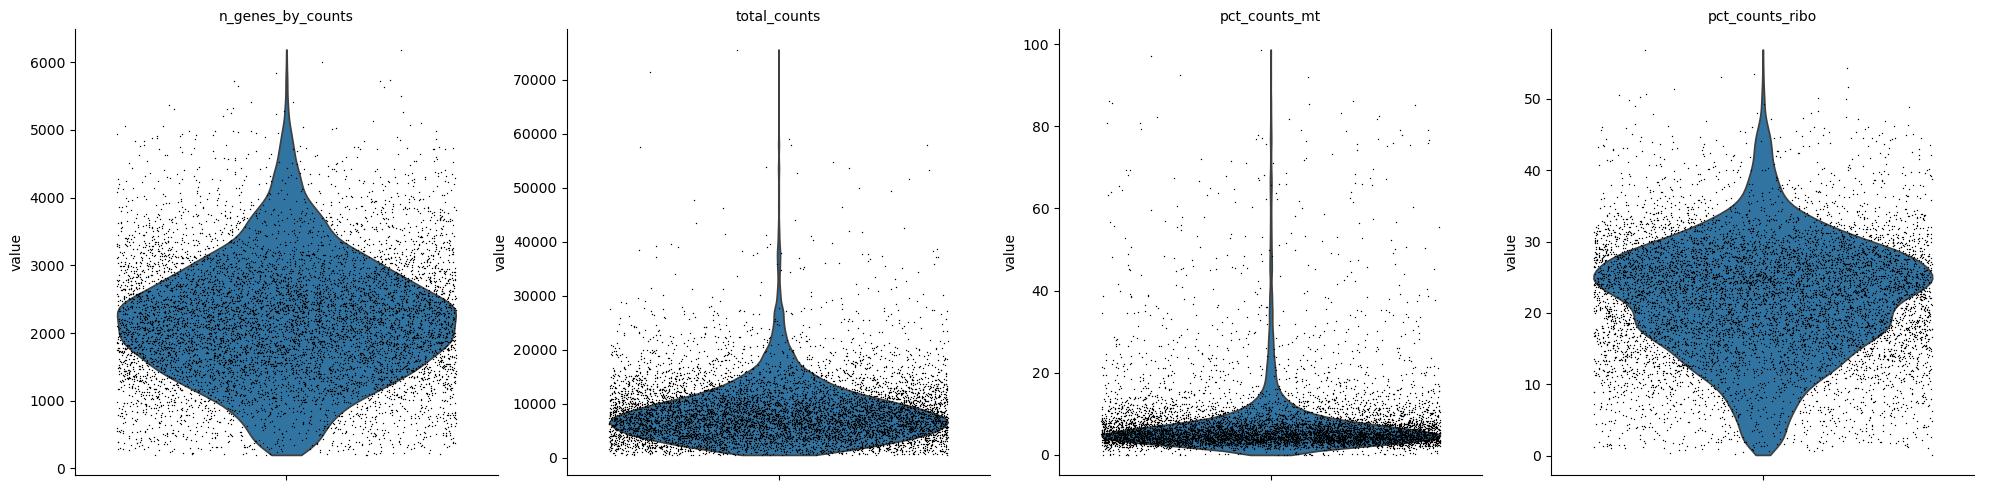

In [90]:
#plot qc metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, \
             multi_panel=True)

In [92]:
#In the publication, it indicates that unwanted variations and low-quality cells were filtered 
#by removing cells with high and low (>6000 and <200) UMI-counts
adata = adata[(adata.obs.n_genes_by_counts > 200 ) & (adata.obs.n_genes_by_counts < 6000)]
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
GGGACAACAGGCTCTG-1,False,204,1178.0,931.0,79.032257,91.0,7.724958,204
AGATGAATCTCACCCA-1,False,204,931.0,719.0,77.228783,15.0,1.611171,204
TATCCTAAGGTCTGGA-1,False,205,811.0,543.0,66.954384,25.0,3.082614,205
ATTCCTACAAAGTGTA-1,False,207,1248.0,984.0,78.846153,43.0,3.445513,207
CATGGTAAGCATGCAG-1,False,208,907.0,628.0,69.239250,12.0,1.323043,208
...,...,...,...,...,...,...,...,...
CCGGGTACAGGATTCT-1,False,5652,38577.0,1194.0,3.095109,5294.0,13.723204,5651
ACTTTCACACTTGGCG-1,False,5726,43371.0,1097.0,2.529340,5731.0,13.213899,5726
TCATGTTGTTCGAACT-1,False,5728,51553.0,3969.0,7.698873,10300.0,19.979439,5717
CATACAGTCCTACCAC-1,False,5736,35268.0,917.0,2.600091,5911.0,16.760237,5735


In [93]:
#filter for mt genes
adata = adata[adata.obs.pct_counts_mt < 20]

In [94]:
#filter for ribo genes
adata = adata[adata.obs.pct_counts_ribo < 50]

In [95]:
adata

View of AnnData object with n_obs × n_vars = 7633 × 20953
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# 4. Normalization

In [97]:
#for each row (cell) in the expression matrix, it calculates the total expression value by adding up 
#the counts from all genes (columns) for that cell.
adata.X.sum(axis=1)

matrix([[ 8791.],
        [15876.],
        [12647.],
        ...,
        [ 5098.],
        [ 3856.],
        [17708.]], dtype=float32)

In [98]:
#normalize the count in each cell, so their total count are same value
#normalize every cell to 10000 UMI
sc.pp.normalize_total(adata, target_sum=1e4)

/Applications/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [99]:
adata.X.sum(axis=1)

matrix([[10000.108],
        [10000.015],
        [ 9999.965],
        ...,
        [10000.026],
        [ 9999.939],
        [10000.136]], dtype=float32)

In [100]:
#Logarithmize the data matrix (change to log count)
sc.pp.log1p(adata)

In [101]:
#it is comparable
adata.X.sum(axis=1)

matrix([[2724.1675],
        [3108.071 ],
        [2922.5767],
        ...,
        [2260.1946],
        [2191.144 ],
        [3164.835 ]], dtype=float32)

In [103]:
#save raw data before filtering
adata.raw = adata

# 5. Clustering

In [104]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [105]:
adata.var

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,False,False,17,0.001964,99.803650,17.0,17,False,0.002653,0.382360,-0.686521
AL669831.5,ENSG00000237491,Gene Expression,False,False,173,0.021483,98.001848,186.0,173,False,0.027324,0.546629,-0.327162
FAM87B,ENSG00000177757,Gene Expression,False,False,32,0.003696,99.630400,32.0,32,False,0.006072,0.793192,0.212227
LINC00115,ENSG00000225880,Gene Expression,False,False,112,0.013283,98.706399,115.0,112,False,0.018676,0.657032,-0.085641
FAM41C,ENSG00000230368,Gene Expression,False,False,53,0.006122,99.387849,53.0,53,False,0.007483,0.469960,-0.494885
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,Gene Expression,False,False,289,0.034419,96.662047,298.0,289,False,0.049254,0.601226,-0.207723
AC007325.4,ENSG00000278817,Gene Expression,False,False,458,0.056942,94.710095,493.0,458,False,0.065041,0.429679,-0.583005
AC007325.2,ENSG00000277196,Gene Expression,False,False,5,0.000578,99.942250,5.0,5,False,0.000462,-0.209887,-1.982137
AL354822.1,ENSG00000278384,Gene Expression,False,False,35,0.004043,99.595750,35.0,35,False,0.004948,0.470802,-0.493044


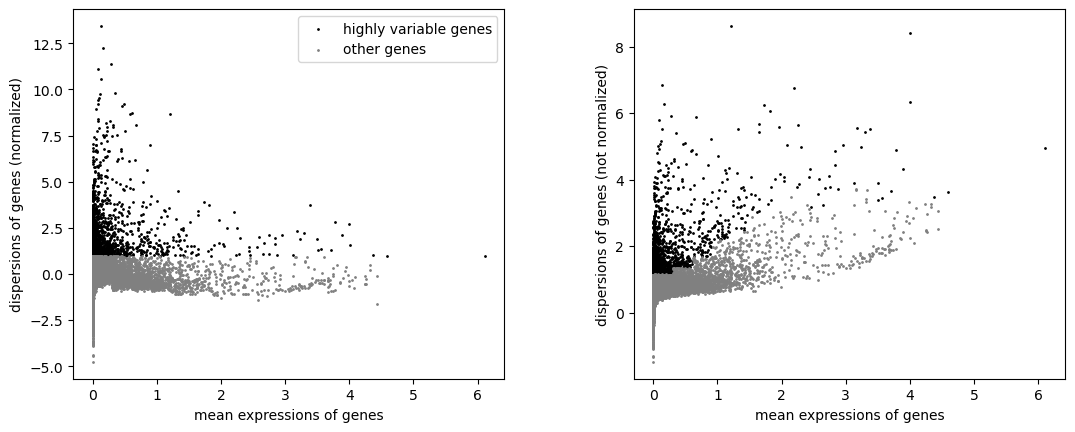

In [106]:
#Plot dispersions or normalized variance versus means for genes.
#gene with high dispersion = highly variable genes
#this is the way to reduce the number of dimensions of the dataset
sc.pl.highly_variable_genes(adata)

In [107]:
#get only highly_varible genes = 2000 genes
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 7633 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [108]:
#Regress out (mostly) unwanted sources of variation.
#the differences that arise due to 'total_counts','pct_counts_mt','pct_counts_ribo' are regressed.
#this will get rid of variations in the data that are due to processing and sample quality seq artifact
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt','pct_counts_ribo'])

In [109]:
#Scale data to unit variance of that genes and zero mean.
sc.pp.scale(adata, max_value=10)

In [110]:
#PCA: scikit-learn PCA is used, will give 'arpack'
#this will further reduces dimension from 2000 to about 30-50 pca
sc.pp.pca(adata,svd_solver='arpack')

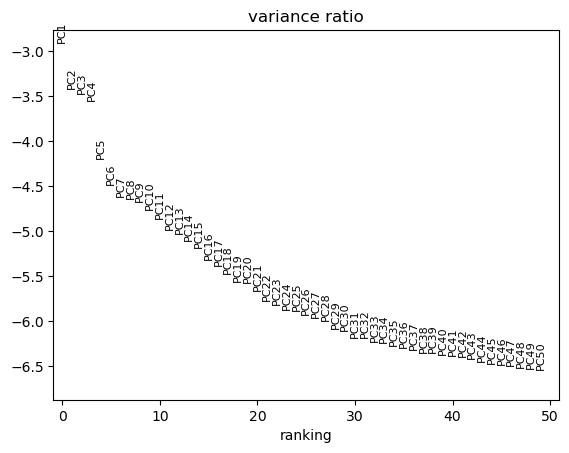

In [126]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [127]:
#the elbow of the plot will use (where you cannot see big difference)~ 40
#calculate the neighbours of the cells using 40pc
#Computes the nearest neighbors distance matrix and a neighborhood graph of observations
sc.pp.neighbors(adata, n_pcs=40)

In [128]:
adata

AnnData object with n_obs × n_vars = 7633 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [129]:
sc.tl.umap(adata)

/Applications/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


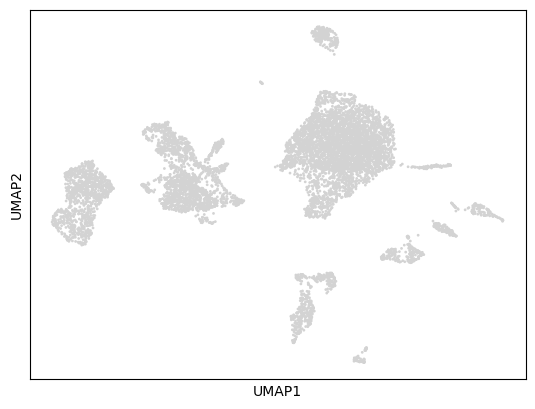

In [130]:
sc.pl.umap(adata)

In [146]:
#assign the cluster using leidenald algorithm
#resolution closer 1 = more clusters
#resolution closer 0 = fewer cluster
sc.tl.leiden(adata, resolution=0.1)

/Applications/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


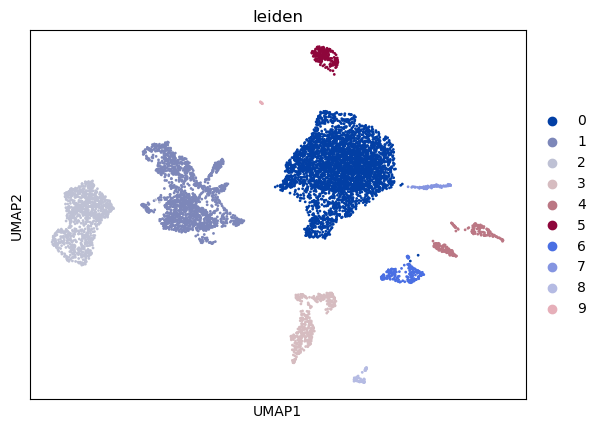

In [147]:
sc.pl.umap(adata, color='leiden')

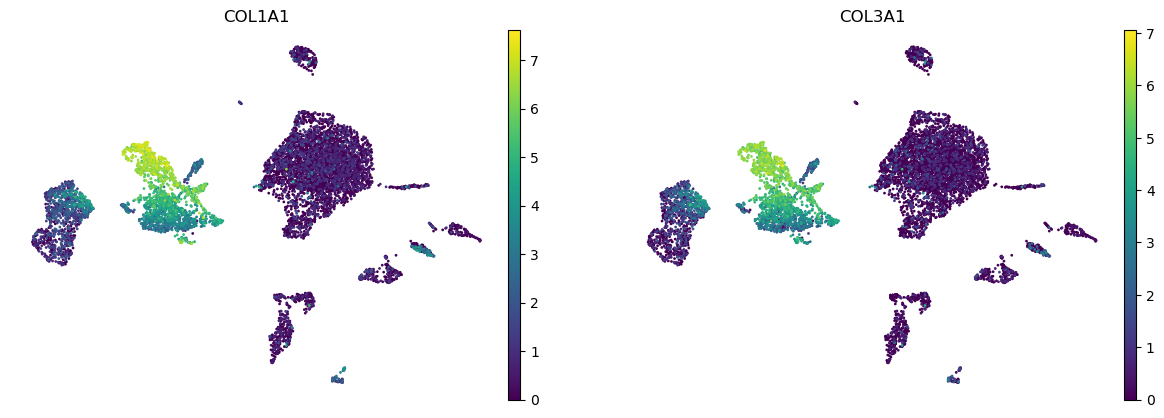

In [148]:
#fibroblast
sc.pl.umap(adata, color=["COL1A1","COL3A1"], frameon=False)

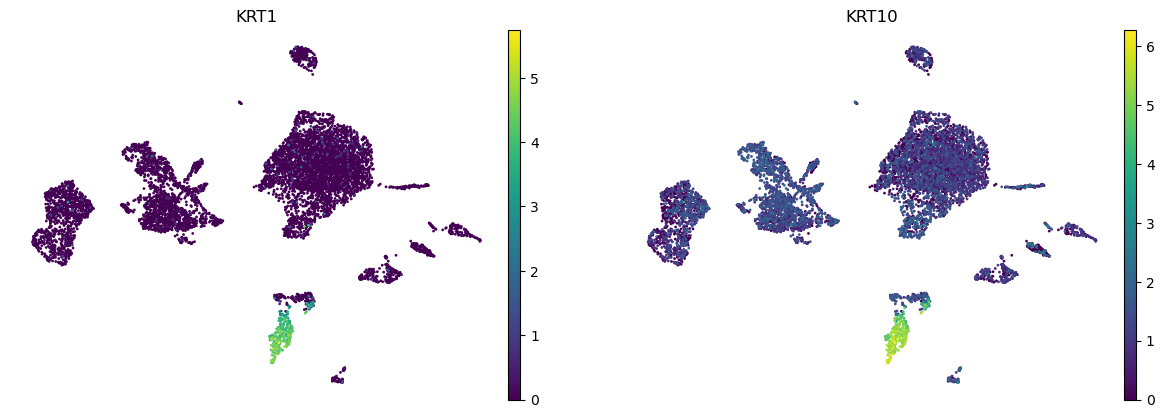

In [150]:
#keratinocytes spinous_cell
sc.pl.umap(adata, color=["KRT1", "KRT10"], frameon=False)

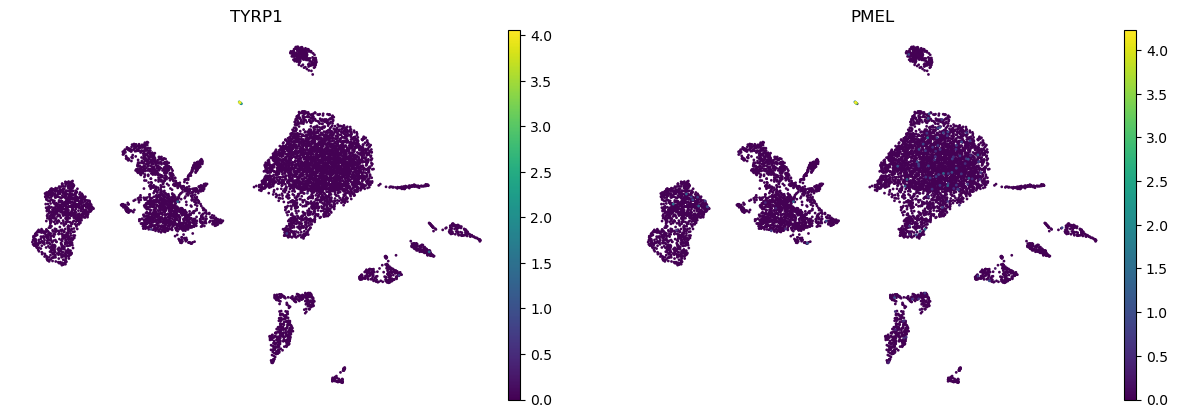

In [151]:
#Melanocytes
sc.pl.umap(adata, color=["TYRP1", "PMEL"], frameon=False)

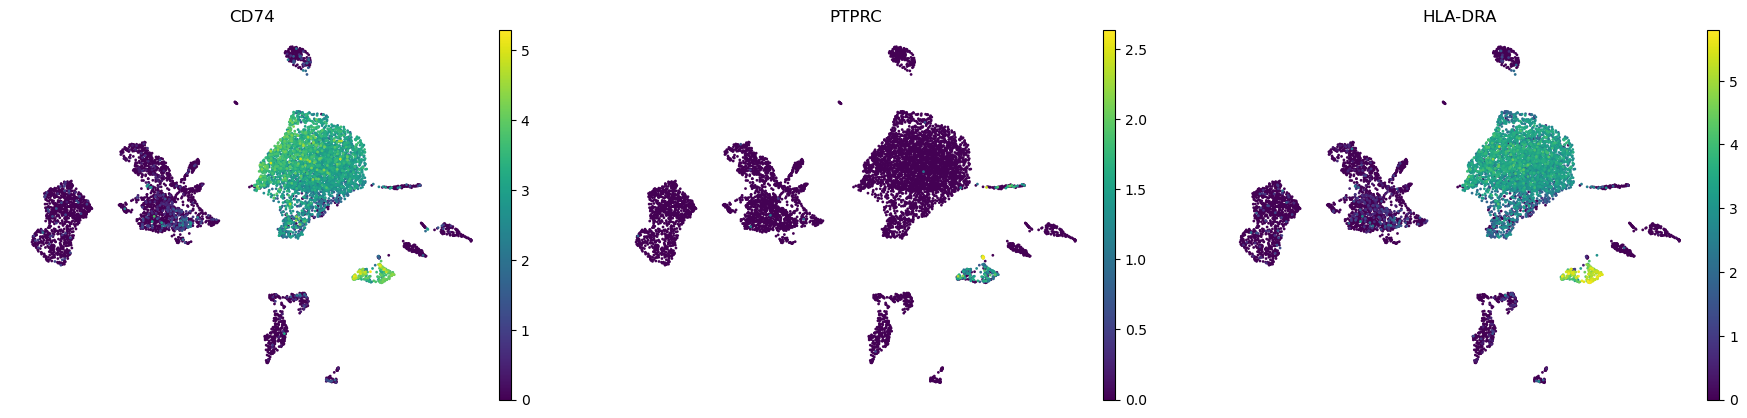

In [152]:
#immune
sc.pl.umap(adata, color=["CD74", "PTPRC","HLA-DRA"], frameon=False)

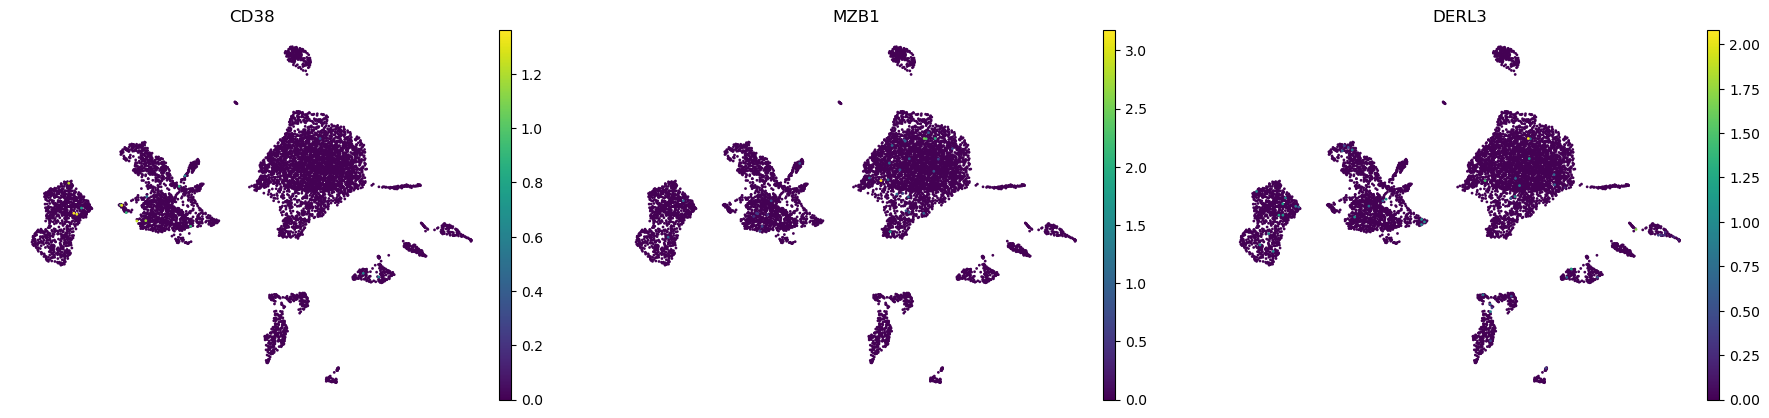

In [153]:
#immune B
sc.pl.umap(adata, color=["CD38","MZB1","DERL3"], frameon=False)

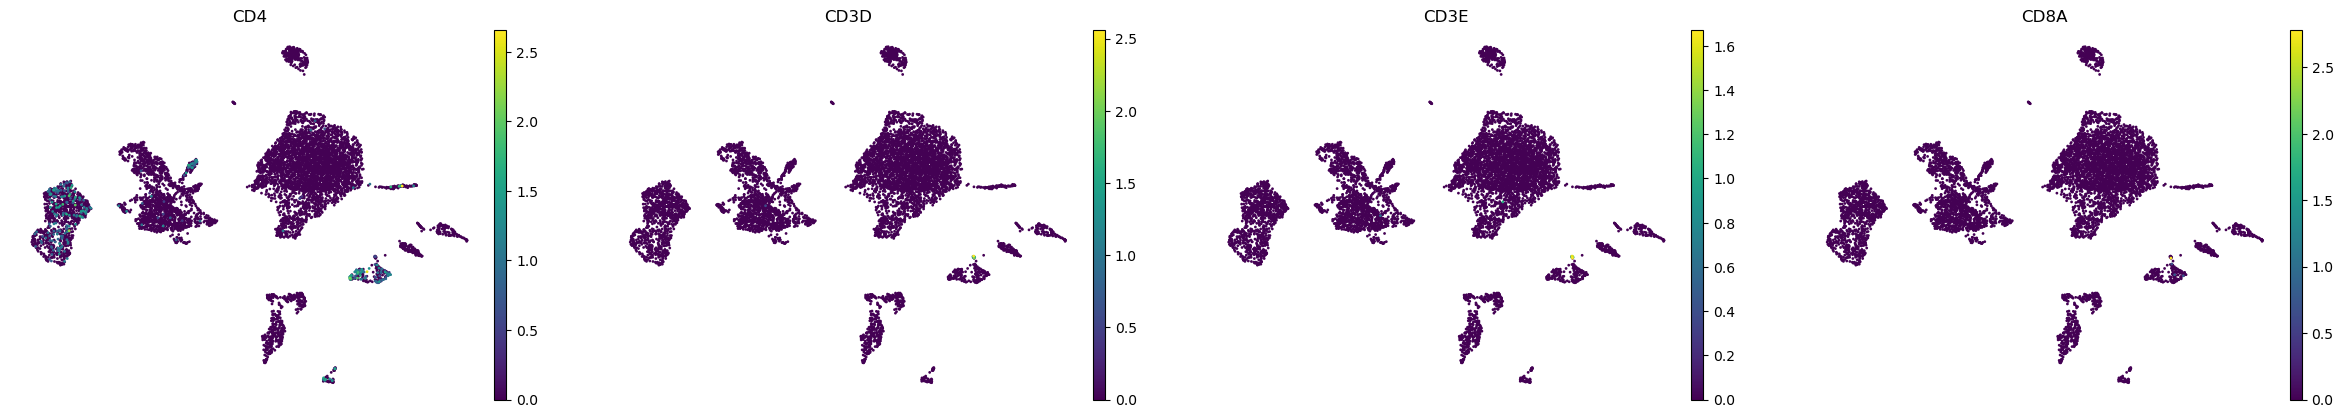

In [156]:
#immune T
sc.pl.umap(adata, color=["CD4","CD3D","CD3E","CD8A"], frameon=False)

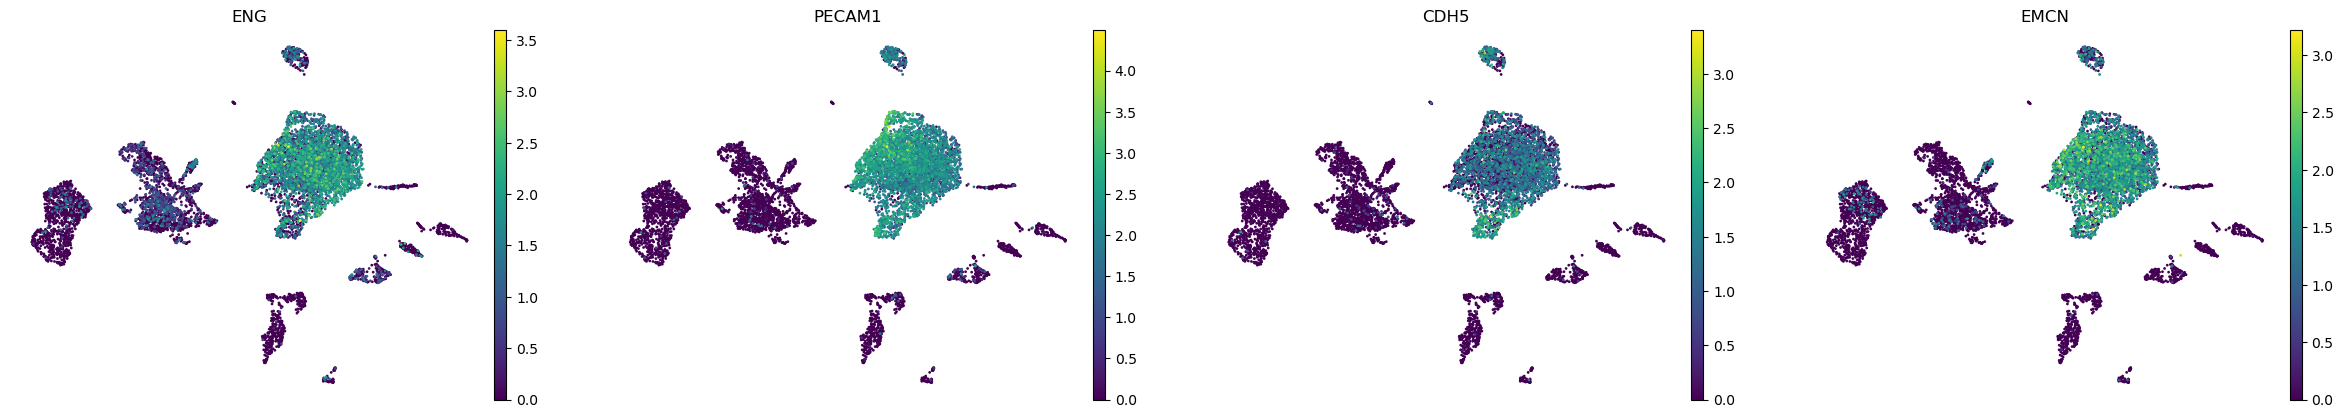

In [157]:
#endothelial cells
sc.pl.umap(adata, color=["ENG","PECAM1","CDH5","EMCN"], frameon=False)

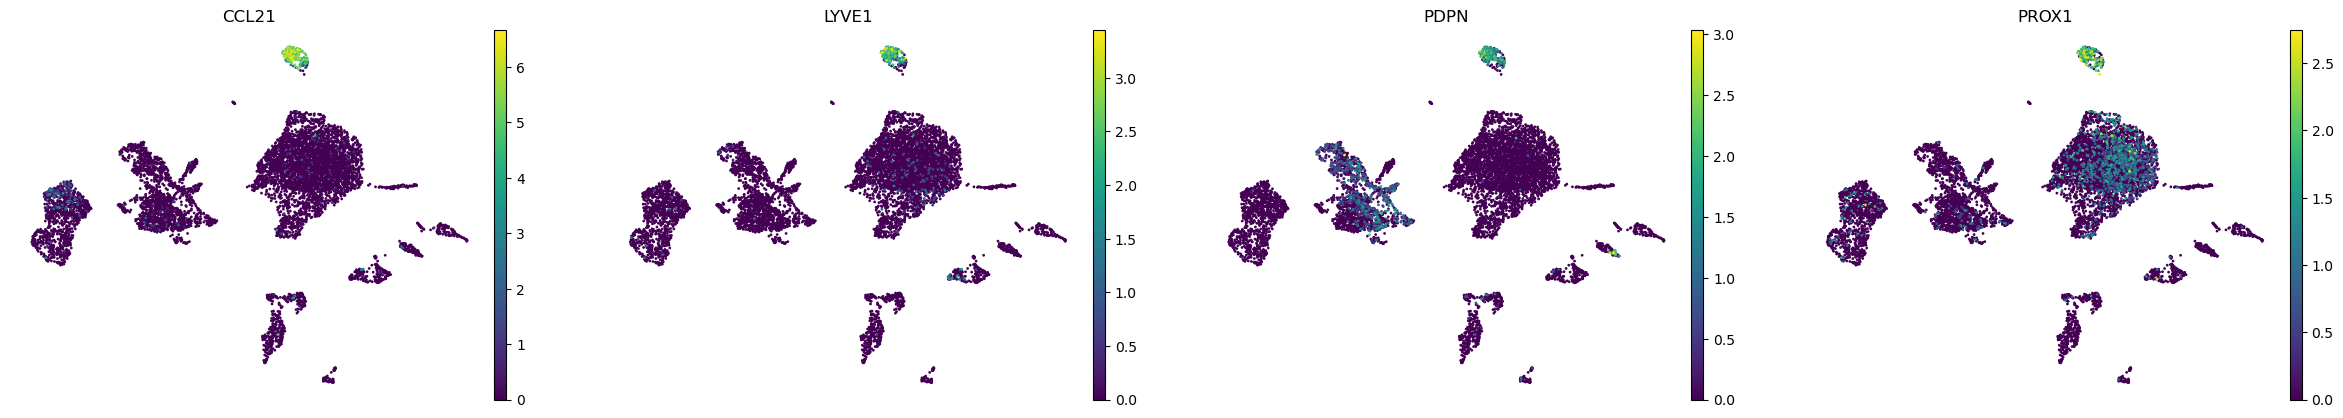

In [158]:
#lymphatic endothelial marker
sc.pl.umap(adata, color=["CCL21","LYVE1","PDPN","PROX1"], frameon=False)

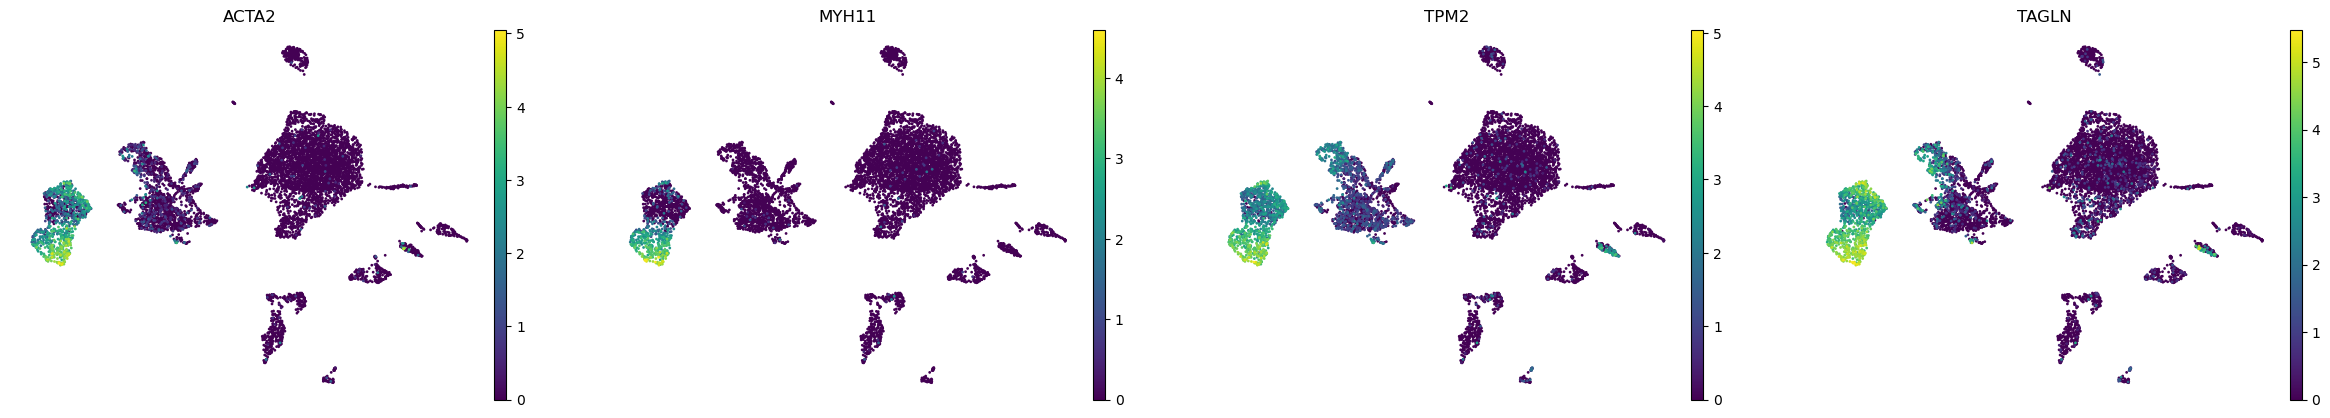

In [159]:
#muscle fiber marker
sc.pl.umap(adata, color=["ACTA2","MYH11","TPM2","TAGLN"], frameon=False)

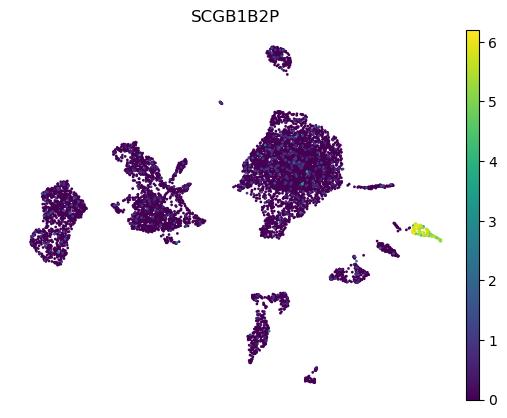

In [160]:
#secretory (glandular) cells
sc.pl.umap(adata, color=["SCGB1B2P"], frameon=False)